In [26]:
%load_ext autoreload
%autoreload 2

from cleaner import clean_pipeline

df = clean_pipeline()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--- 1. STARTING DATA INGESTION ---
Loading Primary Backbone: DEMO_J.xpt
Merging features from: DPQ_J.xpt...
Merging features from: HSQ_J.xpt...
Merging features from: SMQ_J.xpt...
Merging features from: ALQ_J.xpt...
Merging features from: PAQ_J.xpt...
Merging features from: BMX_J.xpt...
Merging features from: BPX_J.xpt...
Merging features from: BIOPRO_J.xpt...
Merging features from: CBC_J.xpt...
Merging features from: HSCRP_J.xpt...
Merging features from: PBCD_J.xpt...
Merging features from: ALB_CR_J.xpt...
Merging features from: VID_J.xpt...
Merging features from: DXX_J.xpt...
--- DATA LOAD COMPLETE. Final Shape: (9254, 44) ---
--- 1. RENAMING ---
--- 2. CREATING IN-ANALYSIS FLAG ---
--- STARTING PROFESSIONAL IMPUTATION (KNN) ---
-> Imputation Complete. Shape: (9254, 38)
--- PIPELINE COMPLETE ---
Full Population Rows (Structure Preserved): 9254
Research-Eligible Rows (In_Analysis=1): 4499


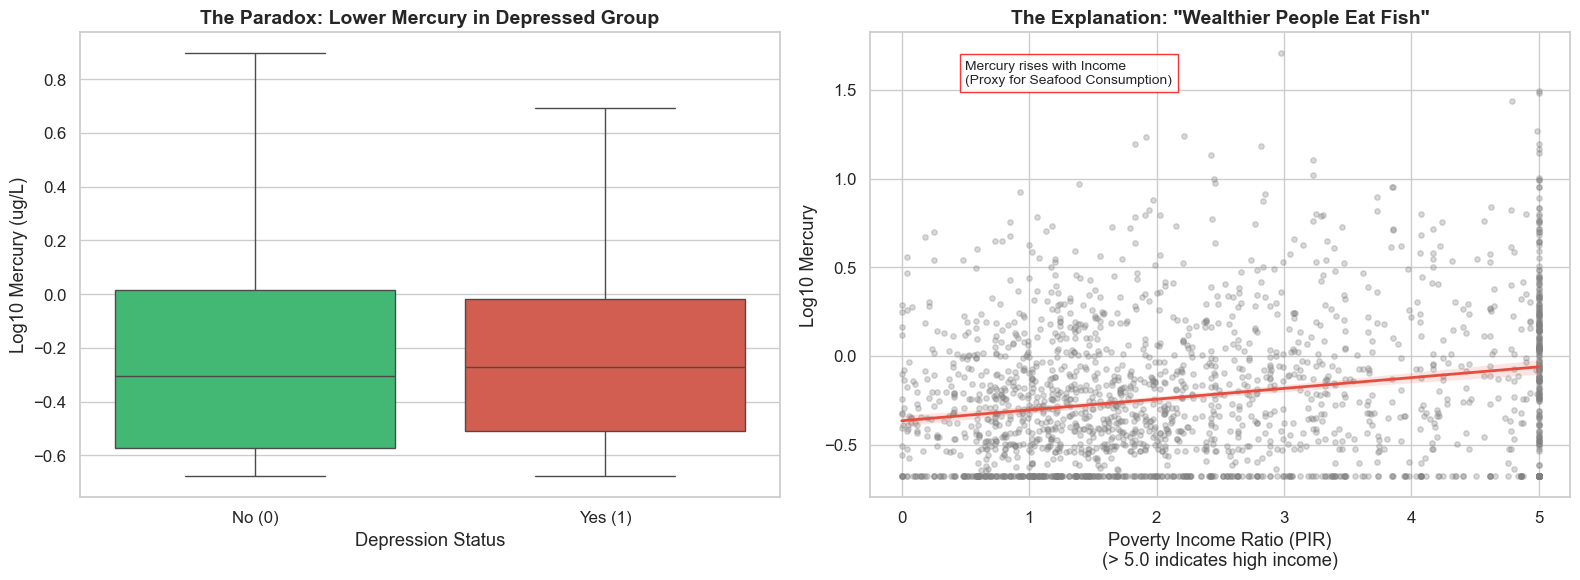

In [27]:
from mercury import analyze_mercury_paradox

analyze_mercury_paradox(df)

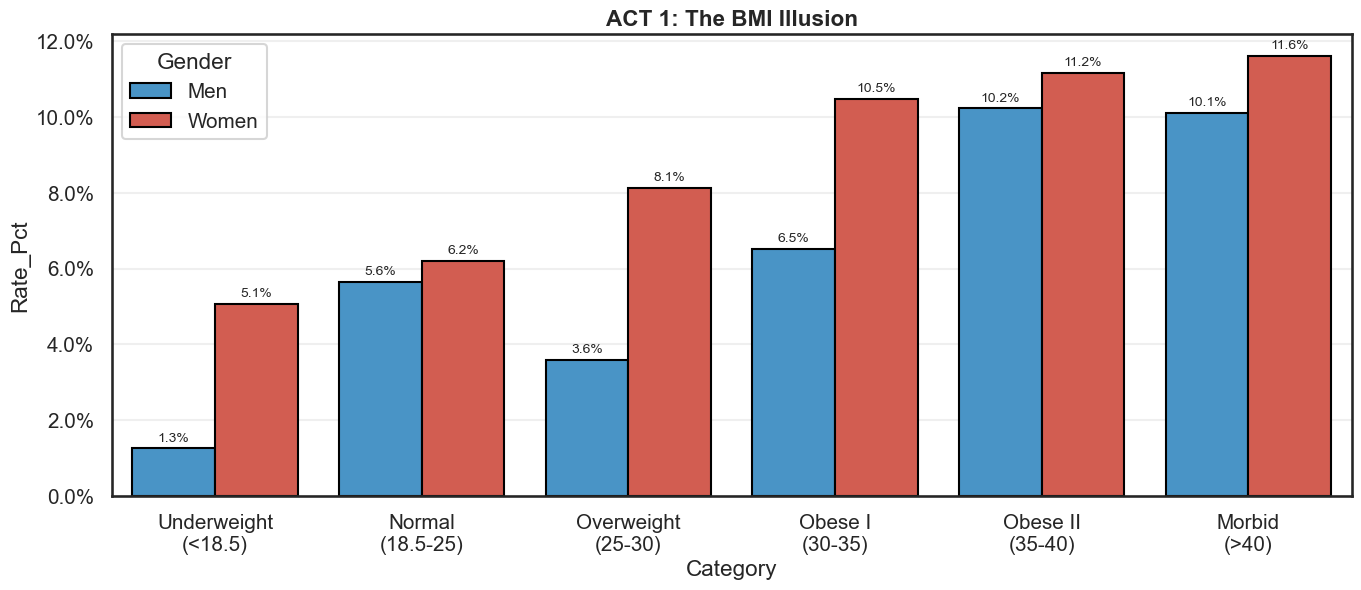

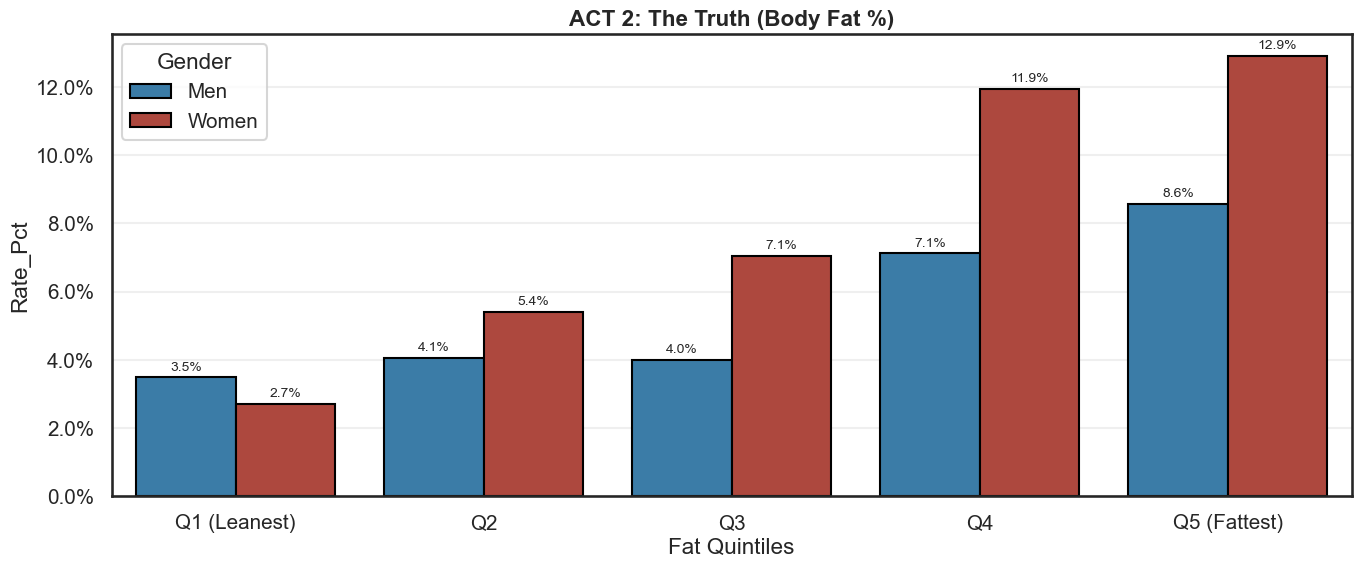

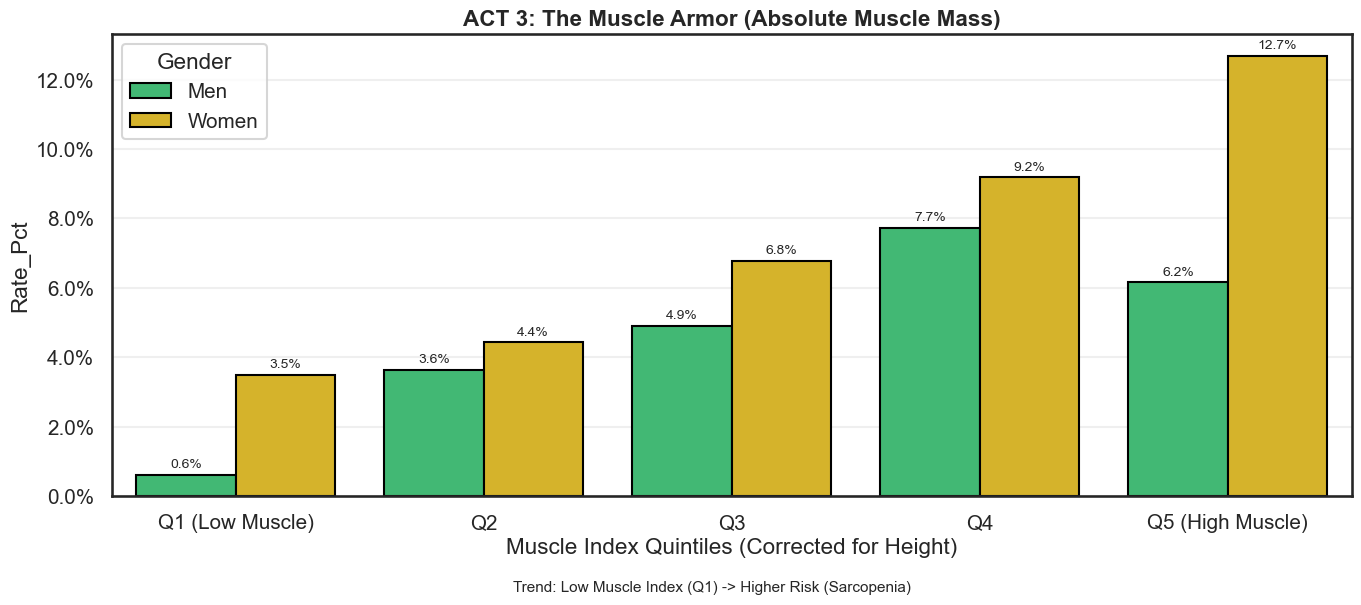

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW


# === 1. ВНУТРЕННЯЯ ФУНКЦИЯ (Копируем прямо сюда) ===
def _calculate_muscle_index(df):
    """Рассчитывает Muscle Mass Index (MMI), чтобы убрать фактор ожирения."""
    local_df = df.copy()

    # 1. Восстанавливаем Рост (в метрах)
    if "Height_m" not in local_df.columns:
        if "Weight_kg" in local_df.columns and "BMI" in local_df.columns:
            # BMI = Weight / Height^2  ->  Height^2 = Weight / BMI
            local_df["Height_m2"] = local_df["Weight_kg"] / local_df["BMI"].replace(
                0, np.nan
            )
        else:
            return None
    else:
        local_df["Height_m2"] = local_df["Height_m"] ** 2

    # 2. Считаем Индекс Мышечной Массы (SMI)
    if "Lean_Mass_g" in local_df.columns:
        local_df["Muscle_Index"] = (local_df["Lean_Mass_g"] / 1000) / local_df[
            "Height_m2"
        ]
        return local_df
    else:
        return None


# === 2. ГЛАВНАЯ ФУНКЦИЯ ===
def analyze_body_composition_story(df: pd.DataFrame):
    # --- Подготовка ---
    # Вызываем функцию, которая теперь точно определена выше
    temp_df = _calculate_muscle_index(df)

    if temp_df is not None:
        local_df = temp_df
        use_muscle_index = True
        muscle_col = "Muscle_Index"
        muscle_label = "Muscle Index (Height-Adjusted)"
    else:
        local_df = df.copy()
        use_muscle_index = False
        muscle_col = "Lean_Mass_g"
        muscle_label = "Absolute Muscle Mass"

    # Таргет
    local_df["Dep_Numeric"] = pd.to_numeric(
        local_df["Depression"], errors="coerce"
    ).fillna(0)

    # Пол
    if pd.api.types.is_numeric_dtype(local_df["Gender"]):
        gender_map = {0: "Men", 1: "Women"}
    else:
        gender_map = {"0": "Men", "1": "Women"}
    local_df["Gender_Label"] = local_df["Gender"].map(gender_map)

    # --- Категоризация ---

    # BMI
    local_df["BMI_Detailed"] = pd.cut(
        local_df["BMI"],
        bins=[0, 18.5, 25, 30, 35, 40, 300],
        labels=[
            "Underweight\n(<18.5)",
            "Normal\n(18.5-25)",
            "Overweight\n(25-30)",
            "Obese I\n(30-35)",
            "Obese II\n(35-40)",
            "Morbid\n(>40)",
        ],
    )

    # Fat Quintiles
    if "Body_Fat_Pct" in local_df.columns:
        local_df["Fat_Quintile"] = local_df.groupby("Gender_Label")[
            "Body_Fat_Pct"
        ].transform(
            lambda x: pd.qcut(
                x, 5, labels=["Q1 (Leanest)", "Q2", "Q3", "Q4", "Q5 (Fattest)"]
            )
        )

    # Muscle Quintiles
    if muscle_col in local_df.columns:
        local_df["Muscle_Quintile"] = local_df.groupby("Gender_Label")[
            muscle_col
        ].transform(
            lambda x: pd.qcut(
                x, 5, labels=["Q1 (Low Muscle)", "Q2", "Q3", "Q4", "Q5 (High Muscle)"]
            )
        )

    # --- Статистика ---
    def get_stats(col):
        stats = []
        if col not in local_df.columns:
            return pd.DataFrame()

        for gen in ["Men", "Women"]:
            sub = local_df[local_df["Gender_Label"] == gen]
            if sub.empty:
                continue
            for cat in sub[col].dropna().unique().sort_values():
                grp = sub[sub[col] == cat]
                if len(grp) > 30:
                    wm = DescrStatsW(grp["Dep_Numeric"], weights=grp["MEC_Weight"]).mean
                    stats.append({"Category": cat, "Gender": gen, "Rate_Pct": wm * 100})
        return pd.DataFrame(stats)

    # --- Визуализация ---
    sns.set_theme(style="white", context="talk", font_scale=0.9)

    # ACT 1: BMI
    plt.figure(figsize=(16, 6))
    df_bmi = get_stats("BMI_Detailed")
    if not df_bmi.empty:
        ax = sns.barplot(
            x="Category",
            y="Rate_Pct",
            hue="Gender",
            data=df_bmi,
            palette={"Men": "#3498db", "Women": "#e74c3c"},
            edgecolor="black",
        )
        plt.title("ACT 1: The BMI Illusion", fontweight="bold")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.grid(axis="y", alpha=0.3)
        for c in ax.containers:
            ax.bar_label(c, fmt="%.1f%%", padding=3, fontsize=10)
        plt.show()

    # ACT 2: FAT
    plt.figure(figsize=(16, 6))
    df_fat = get_stats("Fat_Quintile")
    if not df_fat.empty:
        ax = sns.barplot(
            x="Category",
            y="Rate_Pct",
            hue="Gender",
            data=df_fat,
            palette={"Men": "#2980b9", "Women": "#c0392b"},
            edgecolor="black",
        )
        plt.title("ACT 2: The Truth (Body Fat %)", fontweight="bold")
        plt.xlabel("Fat Quintiles")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.grid(axis="y", alpha=0.3)
        for c in ax.containers:
            ax.bar_label(c, fmt="%.1f%%", padding=3, fontsize=10)
        plt.show()

    # ACT 3: MUSCLE
    plt.figure(figsize=(16, 6))
    df_muscle = get_stats("Muscle_Quintile")
    if not df_muscle.empty:
        ax = sns.barplot(
            x="Category",
            y="Rate_Pct",
            hue="Gender",
            data=df_muscle,
            palette={"Men": "#2ecc71", "Women": "#f1c40f"},
            edgecolor="black",
        )
        plt.title(f"ACT 3: The Muscle Armor ({muscle_label})", fontweight="bold")
        plt.xlabel("Muscle Index Quintiles (Corrected for Height)")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.grid(axis="y", alpha=0.3)

        plt.figtext(
            0.5,
            -0.05,
            "Trend: Low Muscle Index (Q1) -> Higher Risk (Sarcopenia)",
            ha="center",
            fontsize=11,
            bbox={"facecolor": "white", "alpha": 0.5},
        )

        for c in ax.containers:
            ax.bar_label(c, fmt="%.1f%%", padding=3, fontsize=10)
        plt.show()


# === ЗАПУСК ===
analyze_body_composition_story(df)

In [ ]:
import pandas as pd


# === 1. ВНУТРЕННЯЯ ФУНКЦИЯ РАСЧЕТА ===
def _prep_data(df):
    local_df = df.copy()

    # А. Восстанавливаем Рост (в метрах)
    if "Height_m" not in local_df.columns:
        if "Weight_kg" in local_df.columns and "BMI" in local_df.columns:
            local_df["Height_m2"] = local_df["Weight_kg"] / local_df["BMI"].replace(
                0, np.nan
            )
        else:
            return None
    else:
        local_df["Height_m2"] = local_df["Height_m"] ** 2

    # Б. Считаем Индекс Мышечной Массы (SMI)
    if "Lean_Mass_g" in local_df.columns:
        local_df["Muscle_Index"] = (local_df["Lean_Mass_g"] / 1000) / local_df[
            "Height_m2"
        ]

    # В. Таргет и Пол
    local_df["Dep_Numeric"] = pd.to_numeric(
        local_df["Depression"], errors="coerce"
    ).fillna(0)

    if pd.api.types.is_numeric_dtype(local_df["Gender"]):
        gender_map = {0: "Men", 1: "Women"}
    else:
        gender_map = {"0": "Men", "1": "Women"}
    local_df["Gender_Label"] = local_df["Gender"].map(gender_map)

    return local_df


# === 2. ГЛАВНАЯ ФУНКЦИЯ ===
def analyze_body_composition_final(df: pd.DataFrame):
    # --- Подготовка ---
    local_df = _prep_data(df)
    if local_df is None:
        print("Ошибка данных")
        return

    # --- Категоризация ---

    # 1. BMI (6 категорий)
    local_df["BMI_Detailed"] = pd.cut(
        local_df["BMI"],
        bins=[0, 18.5, 25, 30, 35, 40, 300],
        labels=[
            "Underweight\n(<18.5)",
            "Normal\n(18.5-25)",
            "Overweight\n(25-30)",
            "Obese I\n(30-35)",
            "Obese II\n(35-40)",
            "Morbid\n(>40)",
        ],
    )

    # 2. Жир (Квинтили) - Все население
    if "Body_Fat_Pct" in local_df.columns:
        local_df["Fat_Quintile"] = local_df.groupby("Gender_Label")[
            "Body_Fat_Pct"
        ].transform(
            lambda x: pd.qcut(
                x, 5, labels=["Q1 (Leanest)", "Q2", "Q3", "Q4", "Q5 (Fattest)"]
            )
        )

    # 3. МЫШЦЫ (С ХИТРОСТЬЮ)
    # Мы фильтруем датасет: оставляем только "Не жирных", чтобы убрать влияние ожирения
    # Мужчины < 25% жира, Женщины < 35% жира
    mask_fit = (
        (local_df["Gender_Label"] == "Men") & (local_df["Body_Fat_Pct"] < 25)
    ) | ((local_df["Gender_Label"] == "Women") & (local_df["Body_Fat_Pct"] < 35))

    # Создаем колонку только для этой группы
    local_df.loc[mask_fit, "Muscle_Quintile_Fit"] = (
        local_df[mask_fit]
        .groupby("Gender_Label")["Muscle_Index"]
        .transform(
            lambda x: pd.qcut(
                x, 5, labels=["Q1 (Weakest)", "Q2", "Q3", "Q4", "Q5 (Strongest)"]
            )
        )
    )

    # --- Статистика ---
    def get_stats(col, df_source=local_df):
        stats = []
        if col not in df_source.columns:
            return pd.DataFrame()

        for gen in ["Men", "Women"]:
            sub = df_source[df_source["Gender_Label"] == gen]
            if sub.empty:
                continue
            for cat in sub[col].dropna().unique().sort_values():
                grp = sub[sub[col] == cat]
                if len(grp) > 20:
                    wm = DescrStatsW(grp["Dep_Numeric"], weights=grp["MEC_Weight"]).mean
                    stats.append({"Category": cat, "Gender": gen, "Rate_Pct": wm * 100})
        return pd.DataFrame(stats)

    # --- Визуализация ---
    sns.set_theme(style="white", context="talk", font_scale=0.8)

    # ACT 1: BMI
    plt.figure(figsize=(14, 6))
    df_bmi = get_stats("BMI_Detailed")
    if not df_bmi.empty:
        ax = sns.barplot(
            x="Category",
            y="Rate_Pct",
            hue="Gender",
            data=df_bmi,
            palette={"Men": "#3498db", "Women": "#e74c3c"},
            edgecolor="black",
        )
        plt.title(
            'ACT 1: The BMI Illusion (Where "Overweight" looks healthy)',
            fontweight="bold",
            loc="left",
        )
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.grid(axis="y", alpha=0.3)
        for c in ax.containers:
            ax.bar_label(c, fmt="%.1f%%", padding=3, fontsize=10)
        plt.show()

    # ACT 2: FAT
    plt.figure(figsize=(14, 6))
    df_fat = get_stats("Fat_Quintile")
    if not df_fat.empty:
        ax = sns.barplot(
            x="Category",
            y="Rate_Pct",
            hue="Gender",
            data=df_fat,
            palette={"Men": "#2980b9", "Women": "#c0392b"},
            edgecolor="black",
        )
        plt.title("ACT 2: The Truth (DXA Body Fat %)", fontweight="bold", loc="left")
        plt.xlabel("Fat Quintiles (Low % -> High %)")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.grid(axis="y", alpha=0.3)
        for c in ax.containers:
            ax.bar_label(c, fmt="%.1f%%", padding=3, fontsize=10)
        plt.show()

    # ACT 3: MUSCLE (FILTERED)
    plt.figure(figsize=(14, 6))
    df_muscle = get_stats("Muscle_Quintile_Fit")  # Используем отфильтрованную колонку

    if not df_muscle.empty:
        # Men = Green, Women = Gold
        ax = sns.barplot(
            x="Category",
            y="Rate_Pct",
            hue="Gender",
            data=df_muscle,
            palette={"Men": "#2ecc71", "Women": "#f1c40f"},
            edgecolor="black",
        )

        plt.title(
            "ACT 3: The Muscle Armor (Analyzed ONLY on Non-Obese subjects)",
            fontweight="bold",
            loc="left",
        )
        plt.xlabel("Muscle Index Quintiles (Comparing Skinny-Weak vs. Athletes)")
        plt.ylabel("Depression Risk (%)")
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.grid(axis="y", alpha=0.3)

        # Пояснение
        plt.figtext(
            0.13,
            0.82,
            "Now we excluded the fat population.\nComparing purely muscle mass.",
            fontsize=10,
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 3},
        )

        for c in ax.containers:
            ax.bar_label(c, fmt="%.1f%%", padding=3, fontsize=10)
        plt.show()
    else:
        print("Недостаточно данных для Muscle Analysis (проверьте DXA)")


# === ЗАПУСК ===
analyze_body_composition_final(df)

Ошибка данных
